In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
bot_or_human = pd.read_pickle('input/cleaneddata.pkl')
output = bot_or_human[bot_or_human.outcome==-1]['bidder_id'].reset_index()
bot_or_human.drop(['bidder_id'],1,inplace=True)
X= 1.0*bot_or_human[bot_or_human.outcome!=-1].drop('outcome', 1).values
y = bot_or_human[bot_or_human.outcome!=-1].outcome.values
X_test = 1.0*bot_or_human[bot_or_human.outcome ==-1].drop('outcome', 1).values
# 通过过采样解决类别不均衡问题
# http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/over-sampling/plot_smote_bordeline_1.html#sphx-glr-auto-examples-over-sampling-plot-smote-bordeline-1-py
# https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/discussion/14661
sm = SMOTE(kind='borderline1')
X_resampled, y_resampled = sm.fit_sample(X, y)

In [3]:
# 基准方法
benchmark = LogisticRegression(C =3*10**9, tol = 0.04, random_state=42,solver='liblinear',n_jobs=-1)
#benchmark.fit(X_resampled, y_resampled)
#pred_test = benchmark.predict_proba(X_test)[:,1]
#output['prediction'] = pd.Series(pred_test, index=output.index)
#output.drop('index', 1)
#output.to_csv('benchmark.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])


### 基准模型得分

![](src/ben.png)

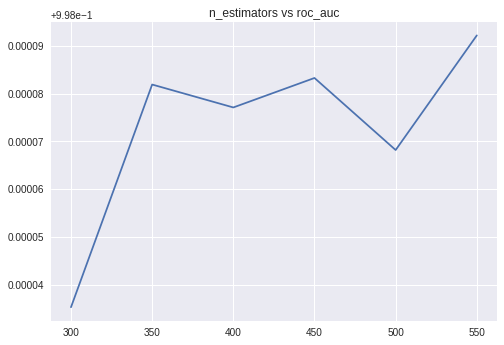

In [6]:
# n_estimators
RFC = RandomForestClassifier(max_depth=None, min_samples_leaf=1, random_state=100,n_jobs = -1,criterion = 'entropy')

ns = range(300,600,50)
test_scores = []
for n in ns:
    clf = RFC.set_params(n_estimators = n)
    test_score = cross_val_score(clf,X_resampled, y_resampled , cv=5, scoring='roc_auc')
    test_scores.append(np.mean(test_score))

plt.plot(ns, test_scores)
plt.title("n_estimators vs roc_auc");

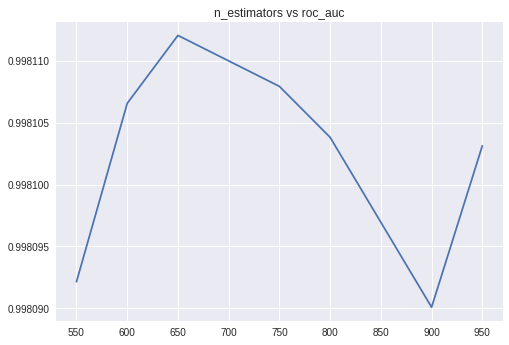

In [8]:
ns = range(550,1000,50)
test_scores = []
for n in ns:
    clf = RFC.set_params(n_estimators = n)
    test_score = cross_val_score(clf,X_resampled, y_resampled , cv=5, scoring='roc_auc')
    test_scores.append(np.mean(test_score))

plt.plot(ns, test_scores)
plt.title("n_estimators vs roc_auc");

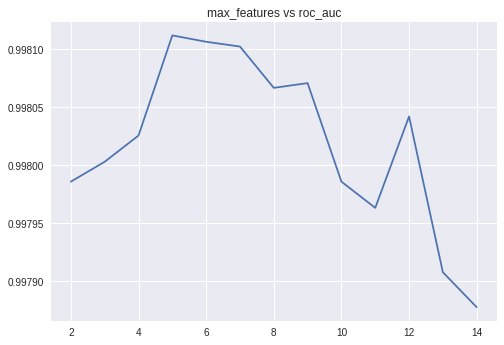

In [10]:
# max_features图
RFC = RandomForestClassifier(max_depth=None, min_samples_leaf=1, random_state=100,n_jobs = -1,criterion = 'entropy',n_estimators=650)


#maxs = range(2,15)
#test_scores = []
# for m in maxs:
#    clf = RFC.set_params( max_features= m)
#    test_score = cross_val_score(clf,X_resampled, y_resampled , cv=5, scoring='roc_auc')
#    test_scores.append(np.mean(test_score))

plt.plot(maxs, test_scores)
plt.title("max_features vs roc_auc");

In [32]:
# 提交随机森林的测试结果
# 用5个不同random_state的预测结果的平均值来做最后的推断
pred_test = np.zeros(X_test.shape[0])
for i in range(1,6):
    RFC = RandomForestClassifier(max_depth=None, min_samples_leaf=1, max_features=5, random_state=i*20
                                 ,n_jobs = -1,criterion = 'entropy',n_estimators=650)
    RFC.fit(X_resampled, y_resampled)
    a = RFC.predict_proba(X_test)[:,1]
    pred_test += a
pred_test1 = 1.0*pred_test/5
output['prediction'] = pd.Series(pred_test1, index=output.index)
output.drop('index', 1)
output.to_csv('RFC.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])

## 随机森林预测得分

![ROC_space](src/rfc.png)

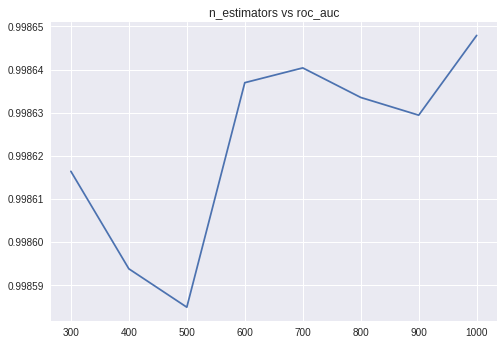

In [11]:
# 极端随机树
# n_estimators
ETC = ExtraTreesClassifier(n_estimators=3000, max_depth=None, min_samples_leaf=1, random_state=0)

ns = range(300,1100,100)
test_scores = []
for n in ns:
    clf = ETC.set_params(n_estimators = n)
    test_score = cross_val_score(clf,X_resampled, y_resampled , cv=5, scoring='roc_auc')
    test_scores.append(np.mean(test_score))

plt.plot(ns, test_scores)
plt.title("n_estimators vs roc_auc");

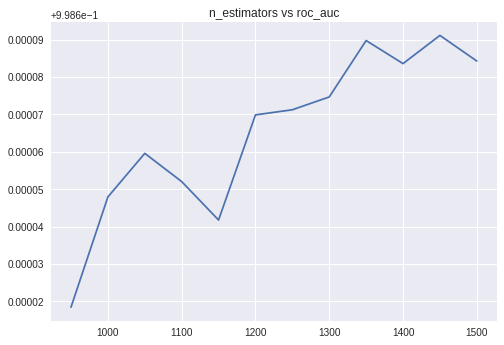

In [12]:
ETC = ExtraTreesClassifier(n_estimators=3000, max_depth=None, min_samples_leaf=1, random_state=0)

ns = range(950,1550,50)
test_scores = []
for n in ns:
    clf = ETC.set_params(n_estimators = n)
    test_score = cross_val_score(clf,X_resampled, y_resampled , cv=5, scoring='roc_auc')
    test_scores.append(np.mean(test_score))

plt.plot(ns, test_scores)
plt.title("n_estimators vs roc_auc");

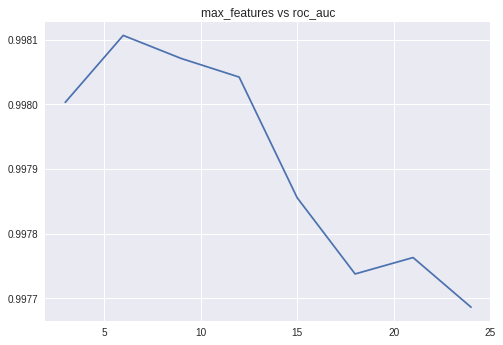

In [13]:
# max_features
ETC = ExtraTreesClassifier(n_estimators=1450, max_depth=None, min_samples_leaf=1, random_state=0)

maxs = range(3,25,3)
test_scores = []
for m in maxs:
    clf = RFC.set_params( max_features= m)
    test_score = cross_val_score(clf,X_resampled, y_resampled , cv=5, scoring='roc_auc')
    test_scores.append(np.mean(test_score))

plt.plot(maxs, test_scores)
plt.title("max_features vs roc_auc");

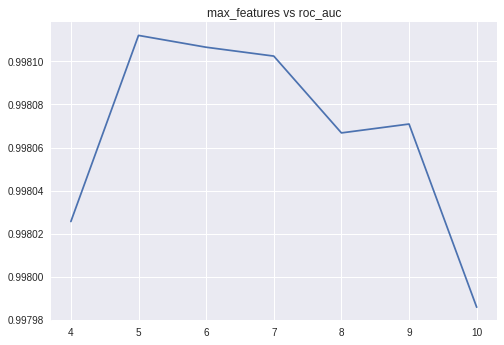

In [14]:
# max_features
ETC = ExtraTreesClassifier(n_estimators=1450, max_depth=None, min_samples_leaf=1, random_state=0)

maxs = range(4,11)
test_scores = []
for m in maxs:
    clf = RFC.set_params( max_features= m)
    test_score = cross_val_score(clf,X_resampled, y_resampled , cv=5, scoring='roc_auc')
    test_scores.append(np.mean(test_score))

plt.plot(maxs, test_scores)
plt.title("max_features vs roc_auc");

In [33]:
ETC = ExtraTreesClassifier(n_estimators=1450,max_features=5, max_depth=None, min_samples_leaf=1, random_state=0)


# 提交极端随机树的测试结果
# 用5个不同random_state的预测结果的平均值来做最后的推断
pred_test = np.zeros(X_test.shape[0])
for i in range(1,6):
    ETC = ExtraTreesClassifier(n_estimators=950,max_features=17,
                               max_depth=None, min_samples_leaf=1, random_state=i*100)
    ETC.fit(X_resampled, y_resampled)
    a = ETC.predict_proba(X_test)[:,1]
    pred_test += a
pred_test2 = 1.0*pred_test/5
output['prediction'] = pd.Series(pred_test2, index=output.index)
output.drop('index', 1)
output.to_csv('ETC.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])


## 极端随机树测试结果

![ROC_space](src/etc.png)

In [7]:
# 梯度提升算法
# 参考https://jessesw.com/XG-Boost/
# 参考https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# step1： 调n_estimators
param_grid = {"n_estimators":range(500,800,20)}

XGB = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.1,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

grid_search = GridSearchCV(XGB,param_grid=param_grid,cv=5, verbose=10,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_estimators=500 ................................................
[CV] ................. n_estimators=500, score=0.992715, total=   1.7s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ................. n_estimators=500, score=0.998849, total=   1.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ................. n_estimators=500, score=0.998554, total=   1.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV] ................. n_estimators=500, score=0.998037, total=   1.8s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.6s remaining:    0.0s


[CV] ................. n_estimators=500, score=0.999863, total=   1.3s
[CV] n_estimators=520 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.0s remaining:    0.0s


[CV] ................. n_estimators=520, score=0.992729, total=   1.6s
[CV] n_estimators=520 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.7s remaining:    0.0s


[CV] ................. n_estimators=520, score=0.998862, total=   1.3s
[CV] n_estimators=520 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.0s remaining:    0.0s


[CV] ................. n_estimators=520, score=0.998616, total=   1.6s
[CV] n_estimators=520 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.6s remaining:    0.0s


[CV] ................. n_estimators=520, score=0.998088, total=   1.6s
[CV] n_estimators=520 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.2s remaining:    0.0s


[CV] ................. n_estimators=520, score=0.999856, total=   1.7s
[CV] n_estimators=540 ................................................
[CV] ................. n_estimators=540, score=0.992661, total=   1.6s
[CV] n_estimators=540 ................................................
[CV] ................. n_estimators=540, score=0.998876, total=   1.6s
[CV] n_estimators=540 ................................................
[CV] ................. n_estimators=540, score=0.998554, total=   1.3s
[CV] n_estimators=540 ................................................
[CV] ................. n_estimators=540, score=0.998109, total=   1.3s
[CV] n_estimators=540 ................................................
[CV] ................. n_estimators=540, score=0.999863, total=   1.3s
[CV] n_estimators=560 ................................................
[CV] ................. n_estimators=560, score=0.992647, total=   2.1s
[CV] n_estimators=560 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.4min finished


{'n_estimators': 760}
0.997663167128


In [9]:
# step 2 调节树的参数 max_depth 


param_grid = {
 'max_depth':range(3,15)
}


XGB  = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=760,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(XGB,param_grid=param_grid,cv=5, verbose=2,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=12, min_child_weight=1 ................................
[CV] ................. max_depth=12, min_child_weight=1, total=   1.6s
[CV] max_depth=12, min_child_weight=1 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ................. max_depth=12, min_child_weight=1, total=   1.8s
[CV] max_depth=12, min_child_weight=1 ................................
[CV] ................. max_depth=12, min_child_weight=1, total=   1.9s
[CV] max_depth=12, min_child_weight=1 ................................
[CV] ................. max_depth=12, min_child_weight=1, total=   1.9s
[CV] max_depth=12, min_child_weight=1 ................................
[CV] ................. max_depth=12, min_child_weight=1, total=   1.7s
[CV] max_depth=12, min_child_weight=2 ................................
[CV] ................. max_depth=12, min_child_weight=2, total=   1.8s
[CV] max_depth=12, min_child_weight=2 ................................
[CV] ................. max_depth=12, min_child_weight=2, total=   3.7s
[CV] max_depth=12, min_child_weight=2 ................................
[CV] ................. max_depth=12, min_child_weight=2, total=   3.5s
[CV] max_depth=12, min_child_weight=2 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.9min finished


{'max_depth': 12, 'min_child_weight': 1}
0.99783311861


In [4]:
# Step 3: Tune gamma

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}


XGB  = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=760,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(XGB,param_grid=param_grid,cv=5, verbose=2,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   1.8s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ........................................ gamma=0.0, total=   1.6s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   1.6s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   1.9s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   1.9s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   1.6s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   1.8s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   1.8s
[CV] gamma=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.1min finished


{'gamma': 0.0}
0.997835859763


In [5]:
# Step 4: Tune subsample and colsample_bytree
param_grid = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}


XGB  = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=760,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(XGB,param_grid=param_grid,cv=5, verbose=1,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.3min finished


{'subsample': 0.8, 'colsample_bytree': 0.7}
0.998167539267


In [9]:
# Step 5: Tuning Regularization Parameters alpha

param_grid = {
 'reg_alpha':[1e-20,0]
}


XGB  = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=760,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(XGB,param_grid=param_grid,cv=5, verbose=1,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


{'reg_alpha': 1e-20}
0.998167539267


In [11]:
# Step 5: Tuning Regularization Parameters reg_lambda

param_grid = {
 'reg_lambda':[1e-7,1e-6,1e-5,1e-4,1e-3]
}



XGB  = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=760,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
  reg_alpha=1e-20,
 seed=27)

grid_search = GridSearchCV(XGB,param_grid=param_grid,cv=5, verbose=1,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_



Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   37.1s finished


{'reg_lambda': 1e-05}
0.99807708122


In [12]:
# # Step 6: 学习速率


param_grid = {
 'learning_rate':np.linspace(0,0.2,20)
}



XGB  = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=760,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

grid_search = GridSearchCV(XGB,param_grid=param_grid,cv=5, verbose=1,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_



Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.7min finished


{'learning_rate': 0.042105263157894736}
0.998125051397


In [6]:
# 用15个不同random_state的预测结果的平均值来做最后的推断

clf  = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=760,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

rounds = 15
preds_mat = np.zeros((len(output.index), rounds))
for i in range(rounds):
    clf.set_params(seed = i + 1)
    clf.fit(X_resampled, y_resampled)
    preds_tmp = clf.predict_proba(X_test)[:, 1]
    preds_mat[:, i] = preds_tmp
pred_test3 = preds_mat.mean(axis = 1)

output['prediction'] = pred_test3
output.drop('index', 1)
output.to_csv('XGB2.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])

## 算法结果
![ROC_space](src/xgb.png)

## 结合三种模型



In [14]:
                                                            
pred_test = np.zeros(len(output.index))
for i in range(15):
    RFC = RandomForestClassifier(max_depth=None, min_samples_leaf=1, max_features=3, random_state=i*20
                                 ,n_jobs = -1,criterion = 'entropy',n_estimators=350)
    RFC.fit(X_resampled, y_resampled)
    a = RFC.predict_proba(X_test)[:,1]
    pred_test += a

for i in range(15):
    ETC = ExtraTreesClassifier(n_estimators=950,max_features=17,n_jobs = -1,
                               max_depth=None, min_samples_leaf=1, random_state=i*10)
    ETC.fit(X_resampled, y_resampled)
    a = ETC.predict_proba(X_test)[:,1]
    pred_test += a
    
for i in range(15):
    clf.set_params(seed = i + 1)
    clf.fit(X_resampled, y_resampled)
    a = clf.predict_proba(X_test)[:,1]
    pred_test += a
pred_test = 1.0*pred_test/45
output['prediction'] = pd.Series(pred_test, index=output.index)
output.drop('index', 1)
output.to_csv('combined.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])
                          

## 结果

![ROC_space](src/comb.png)

In [4]:
#增加模型SVM
#RandomForestClassifier gini
#ExtraTreesClassifier gini
# Adaboost
from sklearn.svm import SVC


svm = SVC(probability=True)

param_grid = { 'C': [10**4,10**5,10**6],
               'kernel': [ 'linear']}

grid_search = GridSearchCV(svm,param_grid=param_grid,cv=5, verbose=2,n_jobs = 2,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] kernel=linear, C=10000 ..........................................
[CV] kernel=linear, C=10000 ..........................................
[CV] ........................... kernel=linear, C=10000, total=   1.9s
[CV] kernel=linear, C=10000 ..........................................
[CV] ........................... kernel=linear, C=10000, total=   1.9s
[CV] kernel=linear, C=10000 ..........................................
[CV] ........................... kernel=linear, C=10000, total=   2.0s
[CV] kernel=linear, C=10000 ..........................................
[CV] ........................... kernel=linear, C=10000, total=   2.2s
[CV] kernel=linear, C=100000 .........................................
[CV] ........................... kernel=linear, C=10000, total=   2.0s
[CV] kernel=linear, C=100000 .........................................
[CV] .......................... kernel=linear, C=100000, total=   6.5s
[CV] kernel=linea

[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  2.2min finished


{'kernel': 'linear', 'C': 1000000}
0.951319865135


In [9]:
abc = AdaBoostClassifier()

param_grid = { 'learning_rate': [0.2],
               'n_estimators': [3000,3500,4000]}

grid_search = GridSearchCV(abc,param_grid=param_grid,cv=5, verbose=2,n_jobs = -1,
                          scoring='roc_auc',error_score=0,refit=True)
grid_search.fit(X_resampled, y_resampled)
print grid_search.best_params_
print grid_search.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=3000, learning_rate=0.2 ............................
[CV] n_estimators=3000, learning_rate=0.2 ............................
[CV] n_estimators=3000, learning_rate=0.2 ............................
[CV] n_estimators=3000, learning_rate=0.2 ............................
[CV] ............. n_estimators=3000, learning_rate=0.2, total= 1.4min
[CV] n_estimators=3000, learning_rate=0.2 ............................
[CV] ............. n_estimators=3000, learning_rate=0.2, total= 1.4min
[CV] n_estimators=3500, learning_rate=0.2 ............................
[CV] ............. n_estimators=3000, learning_rate=0.2, total= 1.4min
[CV] n_estimators=3500, learning_rate=0.2 ............................
[CV] ............. n_estimators=3000, learning_rate=0.2, total= 1.4min
[CV] n_estimators=3500, learning_rate=0.2 ............................
[CV] ............. n_estimators=3000, learning_rate=0.2, total= 1.4min
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.5min finished


{'n_estimators': 3000, 'learning_rate': 0.2}
0.990082508703


## stacking

In [12]:
# https://www.kaggle.com/arthurtok/titanic/introduction-to-ensembling-stacking-in-python
# https://github.com/emanuele/kaggle_pbr/blob/master/blend.py
# 第一阶段模型 xgb,logicRegression,extraTree,Randomforest
xgb  = xgb.XGBClassifier(
 learning_rate =0.0421,
 n_estimators=760,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
  reg_alpha=1e-20,
  reg_lambda=1e-05,
 seed=27)

svm = SVC(probability=True,kernel='linear',C = 1e6, random_state=27)
abc = AdaBoostClassifier(learning_rate=0.2,n_estimators=3000, random_state=27)

ETC = ExtraTreesClassifier(n_estimators=950,max_features=17,n_jobs = -1,
                               max_depth=None, min_samples_leaf=1, random_state=27)
RFC = RandomForestClassifier(max_depth=None, min_samples_leaf=1, max_features=3, random_state=27
                                ,n_jobs = -1,criterion = 'entropy',n_estimators=350)

ETC2 =  ExtraTreesClassifier(n_estimators=500,n_jobs = -1,criterion = 'gini'
                              , min_samples_leaf=1, random_state=27)
RFC2 = RandomForestClassifier( min_samples_leaf=1,  random_state=27
                                ,n_jobs = -1,criterion = 'gini',n_estimators=500)


clfs = [benchmark,xgb,ETC,RFC,ETC2,RFC2]

In [16]:
from sklearn.cross_validation import StratifiedKFold
X_train,y_train = X_resampled, y_resampled
skf = list(StratifiedKFold(y_train, 10))
X_train,y_train = X_resampled, y_resampled
ntrain = len(X_train)
ntest = len(X_test)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((10, ntest))

    for i, (train_index, test_index) in enumerate(skf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)[:, 1]
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:, 1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1).ravel(), oof_test.reshape(-1, 1).ravel()

In [17]:
dataset_blend_train = np.zeros((ntrain, len(clfs)))
dataset_blend_test = np.zeros((ntest, len(clfs)))

for j, clf in enumerate(clfs):
    dataset_blend_train[:, j],dataset_blend_test[:, j] = get_oof(clf, X_train, y_train, X_test)




In [24]:
X_train ,X_test = dataset_blend_train,dataset_blend_test

In [28]:
# stacking初次提交使用xgb模型
xgb = xgb.fit(X_train, y_train)
predictions = xgb.predict_proba(X_test)[:,1]

output['prediction'] = pd.Series(predictions, index=output.index)
output.drop('index', 1)
output.to_csv('stacking.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])


# 模型的稳健性

In [15]:
pred_test = np.zeros(X_test.shape[0])
for i in range(1,6):
    RFC = RandomForestClassifier(max_depth=None, min_samples_leaf=1, max_features=5, random_state=i*20
                                 ,n_jobs = -1,criterion = 'entropy',n_estimators=650)
    RFC.fit(X_resampled, y_resampled)
    a = RFC.predict_proba(X_test)[:,1]
    pred_test += a
pred_test1 = 1.0*pred_test/5
output['prediction'] = pd.Series(pred_test1, index=output.index)
output.drop('index', 1)
output.to_csv('RFC2.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])

pred_test = np.zeros(X_test.shape[0])
for i in range(1,6):
    RFC = RandomForestClassifier(max_depth=None, min_samples_leaf=1, max_features=5, random_state=i*30
                                 ,n_jobs = -1,criterion = 'entropy',n_estimators=650)
    RFC.fit(X_resampled, y_resampled)
    a = RFC.predict_proba(X_test)[:,1]
    pred_test += a
pred_test1 = 1.0*pred_test/5
output['prediction'] = pd.Series(pred_test1, index=output.index)
output.drop('index', 1)
output.to_csv('RFC3.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])

In [16]:
pred_test = np.zeros(X_test.shape[0])
for i in range(1,6):
    RFC = RandomForestClassifier(max_depth=None, min_samples_leaf=1, max_features=5, random_state=i*30
                                 ,n_jobs = -1,criterion = 'entropy',n_estimators=650)
    RFC.fit(X_resampled, y_resampled)
    a = RFC.predict_proba(X_test)[:,1]
    pred_test += a
pred_test1 = 1.0*pred_test/5
output['prediction'] = pd.Series(pred_test1, index=output.index)
output.drop('index', 1)
output.to_csv('RFC4.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])

## 多次预测结果
![ROC_space](src/rfc4.png)

## 学习曲线

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

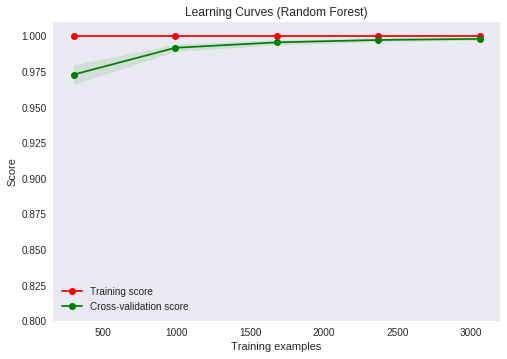

In [18]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = X_resampled, y_resampled

title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(max_depth=None, min_samples_leaf=1, max_features=5, random_state=0
                                 ,n_jobs = -1,criterion = 'entropy',n_estimators=650)

plot_learning_curve(estimator, title, X, y, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)
